In [1]:
# 데이터분석
import pandas as pd
import numpy as np 

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc 

import os
import warnings
import random

# ML/DL 모델 및 sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import FinanceDataReader as fdr

# 경고 끄기
warnings.filterwarnings(action='ignore')

# 데이터프레임 제한 풀기
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_seq_items', None)

from datetime import datetime

from pandas_datareader import data as pdr
import yfinance as yf


In [2]:
!pip install catboost

### 전처리

In [3]:
# 월 평균값을 내셨다면 안해도 되는 코드들입니다.
# 데이터프레임에 월별주가평균, 코스피월별평균만 있으면 됩니다.
# 월 평균 값만 남기고 나머지 빈칸 있는 행 삭제
# df = pd.read_csv('data/9_emart주가_월평균.csv')
# df = df.dropna()
# df.date = pd.to_datetime(df.date)
# df['date'] = df['date'].dt.strftime('%Y-%m')
# df = df.set_index('date')
# df = df.reset_index('date')
'''
# 월 평균값 있을때
df = pd.read_csv('data/10_emart - 주가,코스피원본.csv')
df.date = pd.to_datetime(df.date)
df['date'] = df['date'].dt.strftime('%Y-%m')
df = df.set_index('date')

# MinMaxScaler로 price, kospi 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df)
scaled = scaler.transform(df)
df_scaled = pd.DataFrame(scaled, columns=['pricemm','kospimm'])
df = df.reset_index('date')
df_scaled.insert(0,'date', df['date'] )

df = df.merge(df_scaled,how='left')
df.head()
'''

"\n# 월 평균값 있을때\ndf = pd.read_csv('data/10_emart - 주가,코스피원본.csv')\ndf.date = pd.to_datetime(df.date)\ndf['date'] = df['date'].dt.strftime('%Y-%m')\ndf = df.set_index('date')\n\n# MinMaxScaler로 price, kospi 데이터 정규화\nscaler = MinMaxScaler()\nscaler.fit(df)\nscaled = scaler.transform(df)\ndf_scaled = pd.DataFrame(scaled, columns=['pricemm','kospimm'])\ndf = df.reset_index('date')\ndf_scaled.insert(0,'date', df['date'] )\n\ndf = df.merge(df_scaled,how='left')\ndf.head()\n"

In [4]:
# 월별 날짜로 만들기

def to_month(data):
    data['date'] = data['Date']
    
    for i in range(len(data)):
        year = str(data.Date[i].year)
        month = str(data.Date[i].month)
        date = year + '-' + month
        data['date'][i] = datetime.strptime(str(date), '%Y-%m').date()
        
    data = data.drop(columns=['Date','Open','High','Low','Volume','Change'])
    
    # df column 위치 조절
    data = data[['date','Close']]
    data = data.groupby('date').mean()
    
    data = data.reset_index()
    
    # month column으로 만들기
    for j in range(len(data)):
        data.date = data.date.astype(str)
        data.date[j] = data.date[j][:7]

    return data

In [5]:
# 월별 날짜로 만들기

def to_month_kospi(data):
    data['date'] = data['Date']
    
    for i in range(len(data)):
#         data['Date'][i] = datetime.strptime(str(kospi.Date[i]), '%Y-%m-%d')
        year = str(data.Date[i].year)
        month = str(data.Date[i].month)
        date = year + '-' + month
        data['Date'][i] = datetime.strptime(str(date), '%Y-%m').date()
        
    data = data.drop(columns=['Date','High','Low','Volume','Open','Adj Close'])
    
    # df column 위치 조절
    data = data[['date','Close']]
    data = data.groupby('date').mean()
    
    data = data.reset_index()
    
    # month column으로 만들기
    for j in range(len(data)):
        data.date = data.date.astype(str)
        data.date[j] = data.date[j][:7]

    return data

In [6]:
cj = fdr.DataReader(symbol='097950', start='2018-01-01')
cj = cj.reset_index()
cj = to_month(cj)

In [7]:
kospi = pdr.get_data_yahoo("^KS11",'2018-01-01').reset_index()
kospi = to_month_kospi(kospi)

In [8]:
kospi = kospi.groupby('date').mean()

In [9]:
cj = cj.set_index('date')
# kospi = kospi.set_index('date')

In [10]:
df = pd.merge(cj, kospi,on='date',how='outer')
df = df.rename(columns={'Close_x':'cj_close','Close_y':'kospi_close'})
df = df.reset_index()

In [11]:
df

,date,cj_close,kospi_close
0,2018-01,370250.000000,2520.937722
1,2018-02,338250.000000,2439.104451
2,2018-03,327857.142857,2451.570022
3,2018-04,328500.000000,2458.224761
4,2018-05,347200.000000,2461.300500
5,2018-06,360526.315789,2394.507890
6,2018-07,335022.727273,2284.253651
7,2018-08,342159.090909,2283.796820
8,2018-09,331176.470588,2307.325870
9,2018-10,330119.047619,2153.476696


In [12]:
# MinMaxScaler 데이터 정규화

scaler = MinMaxScaler()

df = df.set_index('date')
scaler.fit(df)
scaled = scaler.transform(df)
df_scaled = pd.DataFrame(scaled, columns=df.columns)

df = df.reset_index()
df_scaled.insert(0,'date', df['date'] )

df = df_scaled

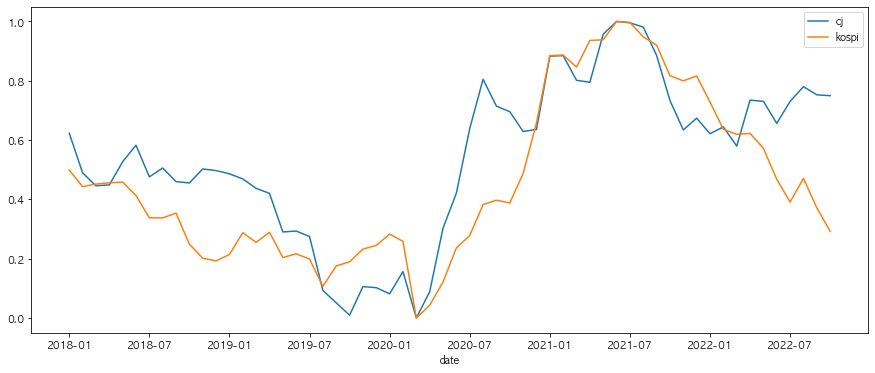

In [13]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['font.size'] = 23
# plt.rcParams['figure.figsize'] = (13, 8) # figsize 고정
ax=sns.lineplot(data=df, x="date", y="cj_close", label='cj')
ax=sns.lineplot(data=df, x="date", y="kospi_close", label='kospi')

total_len = len(df.index)
ax.set_xticks(np.arange(0, total_len + 1, 6))

plt.ylabel('')
# plt.xticks(rotation=15)

plt.show()

In [14]:
df = df.reset_index().drop(columns=['index'])#,'level_0'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         58 non-null     object 
 1   cj_close     58 non-null     float64
 2   kospi_close  58 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.5+ KB


In [16]:
for i in range(len(df)-1):
    df.loc[i+1,'cj_slope'] = df.loc[i+1,'cj_close']-df.loc[i,'cj_close']
    df.loc[i+1,'kospi_slope'] = df.loc[i+1,'kospi_close']-df.loc[i,'kospi_close']

df = df.bfill()

for i in range(len(df)):
    df.loc[i,'diff'] = df.loc[i,'kospi_slope'] - df.loc[i,'cj_slope']

    if df.loc[i,'cj_slope'] < df.loc[i,'kospi_slope']:
        df.loc[i, 'label'] = 1
    else:
        df.loc[i, 'label'] = 0

df

,date,cj_close,kospi_close,cj_slope,kospi_slope,diff,label
0,2018-01,0.623277,0.498638,-0.133878,-0.055578,0.078300,1.0
1,2018-02,0.489398,0.443060,-0.133878,-0.055578,0.078300,1.0
2,2018-03,0.445917,0.451526,-0.043481,0.008466,0.051947,1.0
3,2018-04,0.448607,0.456045,0.002690,0.004520,0.001830,1.0
4,2018-05,0.526842,0.458134,0.078235,0.002089,-0.076146,0.0
5,2018-06,0.582596,0.412771,0.055753,-0.045363,-0.101117,0.0
6,2018-07,0.475896,0.337890,-0.106699,-0.074881,0.031818,1.0
7,2018-08,0.505753,0.337580,0.029856,-0.000310,-0.030167,0.0
8,2018-09,0.459805,0.353560,-0.045948,0.015980,0.061928,1.0
9,2018-10,0.455381,0.249071,-0.004424,-0.104489,-0.100065,0.0


<AxesSubplot:xlabel='label', ylabel='count'>

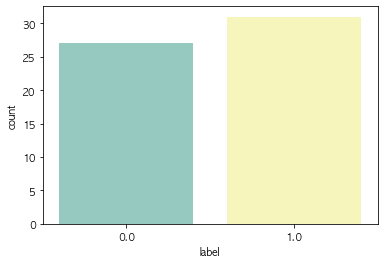

In [17]:
sns.countplot(x=df.label, palette='Set3')

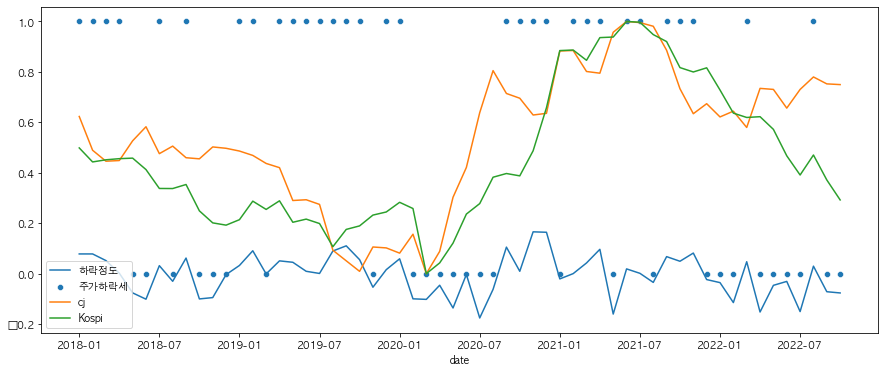

In [18]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

ax = sns.lineplot(data=df, x="date", y="diff", label='하락정도')
ax = sns.scatterplot(data=df, x="date", y="label", label='주가하락세')
ax = sns.lineplot(data=df, x="date", y="cj_close", label='cj')
ax = sns.lineplot(data=df, x="date", y="kospi_close", label='Kospi')

total_len = len(df.index)
ax.set_xticks(np.arange(0, total_len + 1, 6))

plt.ylabel('')
# plt.xticks(rotation=15)


plt.show()

In [19]:
# df.to_csv('yvalue_cj.csv',index=False)

- 저장해서 액셀로 켜시고 https://docs.google.com/spreadsheets/d/1fgvvsrypJKAZEljnHw-BNQsWu9WNRNBAtiMUwEad9Sc/edit#gid=1221057598 이 파일을 복사해서 각 시트에 y값('downturn'열)을 만든 데이터로 대체하시면 됩니다.
- downturn이 target(y값) feature입니다. 이것만 date 열 오른쪽에 남기고, 그 오른쪽에 필요한 feature를 추가하면 됩니다.
- 카테고리별로 시트를 나눠놨으니 그 시트에 바로 복붙하세요

#### feature importance로 feature selection

In [20]:
'''
# 데이터 불러오기 및 날짜 인덱스 지정
df_f = pd.read_csv('data/10_emart - 동행&후행.csv') # 파일 경로를 수정해주세요
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['k_s - p_s'], axis=1)

from sklearn.tree import DecisionTreeClassifier

# train, test split (8:2)
X_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['downturn'], test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape)
print(X_test.shape)

# 0,1이 고르게 나누어졌을까?
print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

# CART 모델 학습
model = DecisionTreeClassifier(max_depth=3, random_state=1)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)
print('정확도 : ', accuracy_score(y_pred, y_test))

# feature importance 확인
ftr_importances = pd.Series(model.feature_importances_, index = X_train.columns)

ftr_top5 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'AppleGothic'
plt.title('경제 동행&후행 Feature Importances') # 그래프 제목을 변경해주세요
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()
'''

"\n# 데이터 불러오기 및 날짜 인덱스 지정\ndf_f = pd.read_csv('data/10_emart - 동행&후행.csv') # 파일 경로를 수정해주세요\ndf_f.date = pd.to_datetime(df_f.date)\ndf_f = df_f.set_index('date')\ndf_f = df_f.drop(['k_s - p_s'], axis=1)\n\nfrom sklearn.tree import DecisionTreeClassifier\n\n# train, test split (8:2)\nX_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['downturn'], test_size=0.2, random_state=0)\ntrain_cnt = y_train.count()\ntest_cnt = y_test.count()\nprint(X_train.shape)\nprint(X_test.shape)\n\n# 0,1이 고르게 나누어졌을까?\nprint(y_train.value_counts()/train_cnt)\nprint(y_test.value_counts()/test_cnt)\n\n# CART 모델 학습\nmodel = DecisionTreeClassifier(max_depth=3, random_state=1)\nmodel.fit(X_train, y_train)\n\n# predict\ny_pred = model.predict(X_test)\nprint('정확도 : ', accuracy_score(y_pred, y_test))\n\n# feature importance 확인\nftr_importances = pd.Series(model.feature_importances_, index = X_train.columns)\n\nftr_top5 = ftr_importances.sort_values(ascending=False)[:20]\n\nplt.figure(figsize=(8,

- 이런 식으로 상위에 뜬 feature만 selection해서 새로운 데이터 프레임을 만듭니다(액셀 작업 추천)
- accuracy가 0.7 이 넘는 데이터에서 나온 feature를 넣는게 좋았던 것 같습니다.

## Grid Search

In [21]:
!pip install openpyxl

In [22]:
from xgboost import XGBClassifier
import xgboost
from sklearn import model_selection

# 데이터 불러오기 및 날짜 인덱스 지정
df_f = pd.read_excel('data/cj_feature_18_22.xlsx') # 파일 경로를 수정해주세요
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['diff'], axis=1)

In [23]:
df_f

,label,동행종합지수(2015=100),광공업생산지수(전월비)(%),소매판매액지수(전월비)(%),후행종합지수(2015=100),소비재수입액(전월비)(%),소비자물가지수,농축수산물_물가,기타농산물_물가,내구재_물가,kospi전일대비월평균,kospi거래대금_m,kospi거래량_m,전일대비등락률_월평균,상장시가총액_m,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,휘발유(95RON),휘발유(92RON),등유,경유(0.001%),경유(0.05%),고유황중유(180cst/3.5%),나프타,미국금리,DJI,NASDAQ,SP500
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,109.4,-0.2,1.0,108.6,2.1,98.106,92.106,100.976,99.686,4.498636,7.142577e+06,3.751605e+05,0.181364,1638788275,2.19,2.44,2.63,2.72,1.66,1.49,1.50,78.70,76.67,80.96,81.85,80.76,58.88,66.13,0.0150,25804.017764,7279.498047,2789.803816
2018-02-01,1,109.9,0.3,0.1,109.0,2.4,98.855,96.765,103.595,99.489,-7.727778,6.886748e+06,4.045120e+05,-0.302222,1607400127,2.28,2.54,2.77,2.82,1.65,1.49,1.50,76.98,74.15,80.03,78.07,77.46,56.97,61.23,0.0150,24981.545230,7161.772641,2705.155248
2018-03-01,1,110.2,0.4,1.3,109.3,0.7,98.751,93.794,101.234,100.208,0.880476,6.883678e+06,3.847098e+05,0.040000,1628916156,2.27,2.50,2.71,2.83,1.65,1.49,1.50,77.14,74.26,79.00,78.39,77.73,56.96,62.89,0.0175,24582.170387,7311.506696,2702.773821
2018-04-01,1,110.3,0.7,0.5,109.6,0.0,98.931,94.180,98.930,100.405,3.310952,7.812027e+06,4.971358e+05,0.136190,1638803401,2.19,2.44,2.66,2.79,1.65,1.47,1.50,81.46,78.41,85.16,84.29,83.71,61.04,66.86,0.0175,24304.212891,7084.142346,2653.625209
2018-05-01,0,110.5,0.6,-0.2,109.9,-0.7,98.979,92.509,100.458,100.887,-3.639048,9.039655e+06,6.392175e+05,-0.143810,1643732872,2.25,2.53,2.76,2.86,1.65,1.50,1.50,87.60,85.30,89.94,90.52,89.52,68.05,74.50,0.0175,24572.532227,7339.327282,2701.493619
2018-06-01,0,110.7,1.2,-0.5,110.2,1.8,98.779,90.217,98.817,100.316,-5.098947,7.546209e+06,4.974135e+05,-0.210526,1599775900,2.18,2.44,2.66,2.81,1.65,1.49,1.50,83.55,81.52,86.94,87.40,86.87,69.19,70.65,0.0200,24790.108352,7645.138532,2754.352888
2018-07-01,1,110.8,0.4,0.0,110.5,0.9,98.590,90.771,97.184,99.567,-1.403182,5.510769e+06,3.413436e+05,-0.058182,1527309146,2.10,2.34,2.55,2.75,1.65,1.49,1.50,83.14,81.12,87.35,86.88,85.52,70.43,72.07,0.0200,24978.231306,7756.863863,2793.643357
2018-08-01,0,110.9,0.3,0.3,110.7,-0.6,99.462,99.166,100.345,99.459,1.255455,5.226407e+06,2.820261e+05,0.057727,1527952909,2.02,2.24,2.46,2.66,1.65,1.50,1.50,84.82,82.43,87.27,88.50,87.61,69.13,71.54,0.0200,25629.988281,7892.233462,2857.820429
2018-09-01,1,110.8,-0.7,-0.5,110.9,-1.1,100.221,104.874,104.816,99.548,1.187647,6.069409e+06,3.196015e+05,0.054118,1542969296,1.95,2.13,2.32,2.40,1.65,1.54,1.50,89.53,87.51,91.65,93.77,92.86,70.69,75.18,0.0225,26232.667969,7983.307412,2901.500514


In [24]:
'''
# train, test split (8:2)
X_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['label'], test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape)
print(X_test.shape)

# 0,1이 고르게 나누어졌을까?
print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

# grid search 로 하이퍼파라미터 탐색
xg_parameters ={'max_depth' : [3,4] , 
                'tree_method' : ['hist'],
                'n_estimators': [32, 200, 300, 400], 
                'learning_rate':[0.3,0.4,0.5], 
                'random_state': [99],
                'gamma': [0.7, 1, 3],
                'min_child_weight' : [1,3,5],
                'max_leaves' : [10,15,20],
                'subsample' : [0.7],
                'colsample_bytree' : [1.0, 1.2, 1.4],
                'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
                'eta' : [0.3,0.5,0.7]
                }

model = XGBClassifier()

grid_search_xg = model_selection.GridSearchCV ( estimator = model, param_grid = xg_parameters, scoring = 'accuracy' )
grid_search_xg.fit( X_train, y_train )
best_xg = grid_search_xg.best_params_
best_xg
print('xgboost best estimator : ',grid_search_xg.best_estimator_)
print('xgboost best param : ',grid_search_xg.best_params_)
print('xgboost best accuracy : ',grid_search_xg.best_score_)
'''

"\n# train, test split (8:2)\nX_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['label'], test_size=0.2, random_state=0)\ntrain_cnt = y_train.count()\ntest_cnt = y_test.count()\nprint(X_train.shape)\nprint(X_test.shape)\n\n# 0,1이 고르게 나누어졌을까?\nprint(y_train.value_counts()/train_cnt)\nprint(y_test.value_counts()/test_cnt)\n\n# grid search 로 하이퍼파라미터 탐색\nxg_parameters ={'max_depth' : [3,4] , \n                'tree_method' : ['hist'],\n                'n_estimators': [32, 200, 300, 400], \n                'learning_rate':[0.3,0.4,0.5], \n                'random_state': [99],\n                'gamma': [0.7, 1, 3],\n                'min_child_weight' : [1,3,5],\n                'max_leaves' : [10,15,20],\n                'subsample' : [0.7],\n                'colsample_bytree' : [1.0, 1.2, 1.4],\n                'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],\n                'eta' : [0.3,0.5,0.7]\n                }\n\nmodel = XGBClassifier()\n\ngrid_search_xg = model_selectio

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

xgb = XGBClassifier()
lgb = LGBMClassifier()
gbm = GradientBoostingClassifier()
cat = CatBoostClassifier()
lreg = LogisticRegression() 

# 최적의 파라미터 값 찾아보기
from sklearn.model_selection import GridSearchCV
# XGB
param_xgb = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6,10],
              "n_estimators": [200,300,500,1000]
              }    
# LGB                        
param_lgb = {"learning_rate" : [0.01,0.1,0.2,0.3,0.4,0.5],
             "max_depth" : [25, 50, 75],
             "num_leaves" : [100,300,500,900,1200],
             "n_estimators" : [100, 200, 300,500,800,1000],
             "learning_rate" : [0.01,0.1,0.2,0.3,0.4,0.5]
              }
# GBM              
param_gbm = {"max_depth" : [4,5,6,7,8,9,10],
             "learning_rate" : [0.01,0.1,0.2,0.3,0.4,0.5],
             "n_estimators" : [100,200,300,500]
              }
# CAT
param_cat = {"depth" : [6,4,5,7,8,9,10],
          "iterations" : [250,100,500,1000],
          "learning_rate" : [0.001,0.01,0.1,0.2,0.3], 
          "l2_leaf_reg" : [2,5,10,20,30],
          "border_count" : [254]
          }

# Logistic
param_lreg = { 'C' : [1.0, 3, 5, 7, 10],
              'max_iter': [50, 200, 100, 300, 500,700, 800]
              }

trainX, testX, trainY, testY = train_test_split(df_f.iloc[:,1:], df_f['label'], test_size=0.2, random_state=0)

# cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
gscv_xgb = GridSearchCV (estimator = xgb, param_grid = param_xgb, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=2)
gscv_lgb = GridSearchCV (estimator = lgb, param_grid = param_lgb, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=2)
gscv_gbm = GridSearchCV (estimator = gbm, param_grid = param_gbm, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=2)
gscv_cat = GridSearchCV (estimator = cat, param_grid = param_cat, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=2)
gscv_lreg = GridSearchCV (estimator = lreg, param_grid = param_lreg, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=2)

gscv_xgb.fit(trainX, trainY)
gscv_lgb.fit(trainX, trainY)
gscv_gbm.fit(trainX, trainY)
gscv_cat.fit(trainX, trainY)
gscv_lreg.fit(trainX, trainY)

print("="*30)
print('XGB 파라미터: ', gscv_xgb.best_params_)
print('XGB 예측 정확도: {:.4f}'.format(gscv_xgb.best_score_))
print("="*30)
print('LGB 파라미터: ', gscv_lgb.best_params_)
print('LGB 예측 정확도: {:.4f}'.format(gscv_lgb.best_score_))
print("="*30)
print('GBM 파라미터: ', gscv_gbm.best_params_)
print('GBM 예측 정확도: {:.4f}'.format(gscv_gbm.best_score_))
print("="*30)
print('CAT 파라미터: ', gscv_cat.best_params_)
print('CAT 예측 정확도: {:.4f}'.format(gscv_cat.best_score_))
print("="*30)
print('Lreg 파라미터: ', gscv_lreg.best_params_)
print('Lreg 예측 정확도: {:.4f}'.format(gscv_lreg.best_score_))
print("="*30)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END .max_depth=10, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END .max_depth=10, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END .max_depth=10, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END .max_depth=10, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END .max_depth=10, min_child_weight=1, n_estimators=500; total time=   0.1s
[CV] END .max_depth=10, min_child_weight=1, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, min_child_weight=1, n_estimators=1000; total time=   0.2s


In [ ]:

# 데이터 불러오기 및 날짜 인덱스 지정
df_f = pd.read_excel('lhs/data/cj_feature_18_22.xlsx') # 파일 경로를 수정해주세요
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['diff','동행종합지수(2015=100)', '후행종합지수(2015=100)', 'kospi전일대비월평균'], axis=1)

from sklearn.tree import DecisionTreeClassifier

# train, test split
X_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['label'], test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape)
print(X_test.shape)

print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

# CART 모델
model = DecisionTreeClassifier(max_depth=4, random_state=1)
model.fit(X_train, y_train)
# model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print('정확도 : ',accuracy_score(y_pred, y_test))

ftr_importances = pd.Series(model.feature_importances_, index = X_train.columns)

ftr_top5 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'AppleGothic'
plt.title('Selected Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()


## xgboost

In [ ]:
from xgboost import XGBClassifier
import xgboost

# 데이터 불러오기 및 날짜 인덱스 지정
df_f = pd.read_csv('lhs/data/CJ_feature_ppt.csv') # 파일 경로를 수정해주세요
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['diff','동행종합지수(2015=100)', '후행종합지수(2015=100)', 'kospi전일대비월평균'], axis=1)

# train, test split (8:2)
X_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['label'], test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape)
print(X_test.shape)

# 0,1이 고르게 나누어졌을까?
print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

best_params = {'colsample_bytree': 1.0, 'eta': 0.3, 'gamma': 0.7, 'learning_rate': 0.3, 
               'max_depth': 4, 'max_leaves': 10, 'min_child_weight': 5, 'n_estimators': 300, 
               'random_state': 99, 'reg_alpha': 0.1, 'subsample': 0.7, 'tree_method': 'hist'}
# model
# model = DecisionTreeClassifier(max_depth=3, random_state=1) # 0.75
# model = XGBClassifier(tree_method= 'hist') # acc = 0.6667
# model = XGBClassifier(n_estimators=1000,random_state = 42) # acc = 0.6667
# model = XGBClassifier(gamma=3, learning_rate=0.6,random_state=99) # acc = 0.9167
model = XGBClassifier(prams=best_params)
# model = XGBClassifier(gamma=3, learning_rate=0.3, random_state = 99, tree_method= 'hist') # acc = 0.5
# 가끔 도움 되는 파라미터
# model = XGBClassifier(colsample_bytree=1.0, eta=0.3, gamma=3, learning_rate=0.3, max_depth=3, max_leaves=10, min_child_weight= 1, n_estimators= 400, random_state = 99, reg_alpha= 0.01, subsample= 0.7, tree_method= 'hist')
# subsample= 0.7, tree_method= 'hist' 이거 2개 파라미터 도움 안됨
# model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_train, y_train), (X_valid, y_valid)])
model.fit(X_train, y_train)

# prediction
# xgb_roc_score = roc_auc_score(y_valid, model.predict_proba(X_test)[:,1], average='macro')
# print(xgb_roc_score)

y_pred = model.predict(X_test)
print('정확도 : ',accuracy_score(y_pred, y_test))

fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.rcParams['font.family'] = 'AppleGothic'
xgboost.plot_importance(model, title='feature_importances', xlabel='', ax=ax, max_num_features=20, height=0.4)
# xgboost.plot_importance(xgb, title='feature_importances', xlabel='', grid=False, ax=ax)
plt.show()

#### 하락 팩터 찾기

In [ ]:
## feature selection된 데이터 MinMaxScaling

df_f = df_f.drop(columns=['label'])

# MinMaxScaler로 price, kospi 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df_f)
scaled = scaler.transform(df_f)
df_scaled = pd.DataFrame(scaled, columns=list(df_f.columns))

# 정규화한 데이터에 날짜 열 추가
df_scaled.insert(0,'date', df['date'] )

# 원본데이터에 merge
df = df.merge(df_scaled, how='left')
df = df.fillna(method='ffill')
df

In [ ]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

ax = sns.scatterplot(data=df, x="date", y="label", label='주가하락세')
ax = sns.lineplot(data=df, x="date", y="cj_close", label='cj')
ax = sns.lineplot(data=df, x="date", y="kospi_close", label='kospi')
ax = sns.lineplot(data=df, x="date", y="소비자물가지수", label='소비자물가지수')

total_len = len(df.index)
ax.set_xticks(np.arange(0, total_len + 1, 6))

plt.ylabel('')

plt.show()

- 소비자 물가지수가 일정 지수(약 102) 이하 이면 하락세인 경향을 보인다.
</br>
</br>
- 소비자 물가지수는 꾸준히 높아지고 있지만 주가와 코스피 지수는 상승과 하락을 반복하고 있으므로 큰 연관성을 찾기 어렵다.

In [ ]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

ax = sns.scatterplot(data=df, x="date", y="label", label='주가하락세')
ax = sns.lineplot(data=df, x="date", y="cj_close", label='cj')
ax = sns.lineplot(data=df, x="date", y="kospi_close", label='kospi')
ax = sns.lineplot(data=df, x="date", y="농축수산물_물가", label='농축수산물_물가')
# ax = sns.lineplot(data=df, x="date", y="기타농산물_물가", label='기타농산물_물가', color='lightgreen')

total_len = len(df.index)
ax.set_xticks(np.arange(0, total_len + 1, 6))

plt.ylabel('')

plt.show()

- 농축수산물 물가 상승시에 하락세인 경향을 보인다. 
</br>
</br>
- 2018-7 ~ 2019-01 구간을 보면 농축산물 물가가 상승과 하락을 반복했지만 코스피와 주가는 계속 하락하고 있고, </br>2020-7 ~ 2022-7 구간에서 초반에는 상승과 하락을 동시에 하면서 연관성이 있어 보이지만 2021-7 구간에 주가 가격과 코스피 수치와 아예 반대되는 것으로 보아 깊은 연관성을 갖고 있다고 보기 어렵다

In [ ]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

ax = sns.scatterplot(data=df, x="date", y="label", label='주가하락세')
ax = sns.lineplot(data=df, x="date", y="cj_close", label='cj')
ax = sns.lineplot(data=df, x="date", y="kospi_close", label='kospi')
ax = sns.lineplot(data=df, x="date", y="기준금리", label='기준금리')

total_len = len(df.index)
ax.set_xticks(np.arange(0, total_len + 1, 6))

plt.ylabel('')

plt.show()

- 금리가 하락할 수록 주가와 가격은 올라가고(2019-07 ~ 2021-07), 금리가 상승할 수록 주가와 가격이 낮아지는 것(~ 2019-07, 2021-07 ~)을 볼 수 있다

In [ ]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

ax = sns.scatterplot(data=df, x="date", y="label", label='주가하락세')
ax = sns.lineplot(data=df, x="date", y="cj_close", label='cj')
ax = sns.lineplot(data=df, x="date", y="kospi_close", label='kospi')
ax = sns.lineplot(data=df, x="date", y="기타농산물_물가", label='기타농산물_물가')

total_len = len(df.index)
ax.set_xticks(np.arange(0, total_len + 1, 6))

plt.ylabel('')

plt.show()

- 2018-01 ~ 2018-07 구간에서는 코스피와 같은 하락세의 움직임을 보이지만 2021-05 구간에는 주가와 코스피보다 미리 하락세로 전환되는 것을 볼 수 있다. 상승하는 구간과 하락하는 구간이 주가, 코스피와 대부분 상관관계가 있어 보이나 절대적인 것은 아니며 2022-01 구간에는 기타 농산물 물가가 상승하지만 주가와 코스피는 하락하는 모습을 보이기도 한다 